In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/train.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV
import time

In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


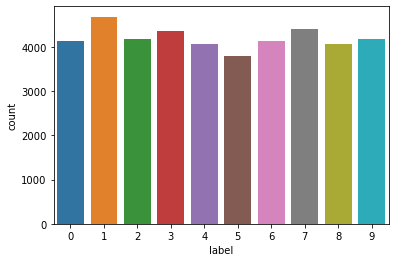

In [5]:
sns.countplot(train['label'])
# target distribution is not skewed

In [6]:
X = train.drop('label', axis=1)
y = train['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train = X_train.values
y_train = y_train.values
X_test = X_test.values
y_test = y_test.values

In [8]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_dt)
print(accuracy)

0.8553571428571428


In [9]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf)
print(accuracy)

0.9614285714285714


In [10]:
lr_model = LogisticRegression(max_iter=100)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_lr)
print(accuracy)

0.9183333333333333


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [11]:
def evaluate_models(models):
    for model in models:
        print("Evaluation for {}".format(type(model).__name__))
        print("----"*20)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test,y_pred)
        print("\nConfusion Matrix:\n",cm)
        ac = accuracy_score(y_test,y_pred)
        print("\nAccuracy:\n",ac)
        print("\nClassification Report:\n")
        print(classification_report(y_test,y_pred))

In [12]:
models = [lr_model, dt_model, rf_model]

In [13]:
evaluate_models(models)

Evaluation for LogisticRegression
--------------------------------------------------------------------------------

Confusion Matrix:
 [[787   0   2   2   3  13   6   1   2   0]
 [  0 887   6   0   1   4   1   2   7   1]
 [  5  12 758  13   9   9  11   8  20   1]
 [  2   3  26 831   0  24   1   9  25  16]
 [  5   1   5   1 779   1  11   3   5  28]
 [  7   2   7  25   8 610  18   2  20   3]
 [  7   1   6   0   3   7 754   1   5   1]
 [  0   2   6  12  13   2   1 819   6  32]
 [  4  11   8  28   6  25   6   4 738   5]
 [  7   3   2  12  20   8   0  28   7 751]]

Accuracy:
 0.9183333333333333

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       816
           1       0.96      0.98      0.97       909
           2       0.92      0.90      0.91       846
           3       0.90      0.89      0.89       937
           4       0.93      0.93      0.93       839
           5       0.87      0.87      0.87       702

In [14]:
def cross_validate_models(models, splits):
    kf = KFold(n_splits=splits,shuffle=True)
    for model in models:
        scores = cross_val_score(model,
                                 X_train,
                                 y_train,
                                 cv=kf,
                                 n_jobs=12,
                                 scoring="accuracy")
        print("Cross-Validation for {}:\n".format(type(model).__name__))
        print("Mean score: ", np.mean(scores))
        print("Variance of score: ", np.std(scores)**2)
        fig = plt.figure(figsize = (10,5))
        ax = fig.add_subplot(111)
        ax = sns.distplot(scores)
        ax.set_xlabel("Cross-Validated Accuracy scores")
        ax.set_ylabel("Frequency")
        ax.set_title('Frequency Distribution of Cross-Validated Accuracy scores for {}'.format(type(model).__name__), fontsize = 15)

In [15]:
model_rf = [rf_model]

Cross-Validation for RandomForestClassifier:

Mean score:  0.9624404761904763
Variance of score:  1.3672760770974962e-05


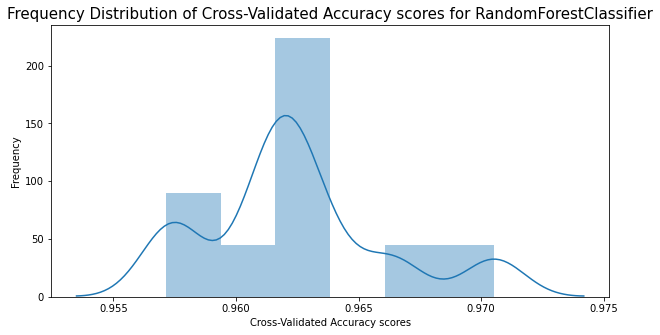

In [16]:
cross_validate_models(model_rf,10)

In [17]:
rf_params = {'bootstrap': [True, False],
 'max_depth': [10, 15, 20, 25, 30, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 400, 600, 800, 1000]}

In [18]:
params = [rf_params]
# params_rf = [rf_params]

tuned_models = []

In [19]:
def hyper_param_tuning(models,params,splits,scorer):
    for i in range(len(models)):
        gsearch = RandomizedSearchCV(estimator=models[i],
                               param_distributions=params[i],
                               scoring=scorer,
                               verbose=2,
                               n_jobs=-1,
                               cv=5)
        start = time.time()
        gsearch.fit(X_train,y_train)
        end = time.time()
        
        print("Grid Search Results for {}:\n".format(type(models[i]).__name__))
        print("Time taken for tuning (in secs): \n", end-start)
        print("Best parameters: \n",gsearch.best_params_)
        print("Best score: \n",gsearch.best_score_)
        tuned_models.append(gsearch.best_estimator_)
        print("\n\n")

In [20]:
# hyper_param_tuning(model_rf,params,10,"accuracy")

Parameter tuning takes a lot of time. Output is not shown here and the parameters tuned are as follows : 

params_tuned = {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}

In [21]:
params_tuned = {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
rf_tuned_model = RandomForestClassifier(**params_tuned)
rf_tuned_model.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_rf_tuned)
print(accuracy)

0.9670238095238095


Random Forest gives accuracy of 0.967 on validation data.

## Neural Network

In [22]:
import itertools
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Lambda
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [23]:
X = X.values.reshape(X.shape[0], 28, 28,1)
X.shape

(42000, 28, 28, 1)

In [24]:
from keras.utils.np_utils import to_categorical

y = to_categorical(y, num_classes = 10)

from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1, random_state=101)

In [25]:
mean_px = Xtrain.mean().astype(np.float32)
std_px = Xtrain.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

In [26]:
optimizer = RMSprop(lr=0.001)
model = Sequential([
    Lambda(standardize, input_shape=(28,28,1)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
    ])
model.compile(optimizer=optimizer, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 28, 28, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [28]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [29]:
batch_size = 32
epochs = 25

model.fit(Xtrain, ytrain, batch_size = batch_size, epochs = epochs, 
         validation_data = (Xtest, ytest), verbose = 2, callbacks=[learning_rate_reduction, es])

Epoch 1/25
1182/1182 - 3s - loss: 0.2350 - accuracy: 0.9288 - val_loss: 0.1466 - val_accuracy: 0.9586
Epoch 2/25
1182/1182 - 3s - loss: 0.1114 - accuracy: 0.9692 - val_loss: 0.1570 - val_accuracy: 0.9636
Epoch 3/25
1182/1182 - 3s - loss: 0.0781 - accuracy: 0.9784 - val_loss: 0.1428 - val_accuracy: 0.9702
Epoch 4/25
1182/1182 - 3s - loss: 0.0609 - accuracy: 0.9836 - val_loss: 0.1307 - val_accuracy: 0.9752
Epoch 5/25
1182/1182 - 3s - loss: 0.0441 - accuracy: 0.9874 - val_loss: 0.1315 - val_accuracy: 0.9736
Epoch 6/25
1182/1182 - 3s - loss: 0.0401 - accuracy: 0.9890 - val_loss: 0.1503 - val_accuracy: 0.9755
Epoch 7/25
1182/1182 - 3s - loss: 0.0359 - accuracy: 0.9900 - val_loss: 0.1575 - val_accuracy: 0.9752
Epoch 00007: early stopping


In [30]:
model.evaluate(Xtest, ytest)

132/132 [==============================] - 0s 2ms/step - loss: 0.1575 - accuracy: 0.9752


[0.15747833251953125, 0.9752380847930908]

## CNN

In [31]:
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape=(28,28,1)))
model1.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))


model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model1.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model1.add(Dropout(0.25))


model1.add(Flatten())
model1.add(Dense(256, activation = "relu"))
model1.add(Dropout(0.5))
model1.add(Dense(10, activation = "softmax"))

In [32]:
model1.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [33]:
Xtrain = Xtrain/255
Xtest = Xtest/255
epochs1 = 15
batch_size1 = 32
model1.fit(Xtrain, ytrain, batch_size = batch_size1, epochs = epochs1, 
         validation_data = (Xtest, ytest), verbose = 2, callbacks=[learning_rate_reduction, es])

Epoch 1/15
1182/1182 - 5s - loss: 0.1921 - accuracy: 0.9400 - val_loss: 0.0391 - val_accuracy: 0.9876
Epoch 2/15
1182/1182 - 6s - loss: 0.0720 - accuracy: 0.9795 - val_loss: 0.0385 - val_accuracy: 0.9890
Epoch 3/15
1182/1182 - 6s - loss: 0.0601 - accuracy: 0.9833 - val_loss: 0.0385 - val_accuracy: 0.9879
Epoch 4/15
1182/1182 - 5s - loss: 0.0550 - accuracy: 0.9848 - val_loss: 0.0503 - val_accuracy: 0.9857
Epoch 5/15
1182/1182 - 5s - loss: 0.0534 - accuracy: 0.9852 - val_loss: 0.0347 - val_accuracy: 0.9912
Epoch 6/15
1182/1182 - 5s - loss: 0.0548 - accuracy: 0.9862 - val_loss: 0.0285 - val_accuracy: 0.9921
Epoch 7/15
1182/1182 - 5s - loss: 0.0552 - accuracy: 0.9844 - val_loss: 0.0379 - val_accuracy: 0.9879
Epoch 8/15
1182/1182 - 5s - loss: 0.0569 - accuracy: 0.9853 - val_loss: 0.0498 - val_accuracy: 0.9895
Epoch 9/15
1182/1182 - 5s - loss: 0.0613 - accuracy: 0.9853 - val_loss: 0.0505 - val_accuracy: 0.9919
Epoch 00009: early stopping


In [38]:
test = pd.read_csv('../input/digit-recognizer/test.csv')

In [39]:
test.shape

(28000, 784)

In [40]:
test_vals = test

In [45]:
image_id = test.index.values

In [61]:
image_id = image_id + 1

In [46]:
test_vals = test_vals.values.reshape(test_vals.shape[0], 28, 28,1)
test_vals.shape

(28000, 28, 28, 1)

In [47]:
test_vals = test_vals/255

In [48]:
predictions = model1.predict(test_vals)

In [53]:
predictions = np.argmax(predictions,axis = 1)

In [56]:
predictions

array([2, 0, 9, ..., 3, 9, 2])

In [63]:
submission1 = pd.DataFrame({
        "ImageId": image_id,
        "Label": predictions
    })

In [64]:
submission1

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [65]:
submission1.to_csv('mysubmission1.csv', index=False)